In [2]:
# Load libraries
!pip install -r /work/NLP_IMDb_Exam/requirements.txt
import numpy as np
import pandas as pd
import torch
import datasets
import evaluate
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 41.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 26.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 46.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 60.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 54.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 49.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 82.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41

2024-12-31 16:32:47.588466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735659167.602917     326 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735659167.607343     326 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 16:32:47.624707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_dict= {
    1 :{
        "name" : "MiniLM_L6",
        "huggingface" : "sentence-transformers/all-MiniLM-L6-v2",
        },

    2 :{
        "name" : "MPNET_base",
        "huggingface" : 'sentence-transformers/all-mpnet-base-v2',
        },    

    3 :{
        "name" : "Instructor",
        "huggingface" : "hkunlp/instructor-large",
    },}

rating_type={
    1 : "average_rating",
    2 : "rating",
}

# Choose a model for a pseudo-function
Chosen_Model= 3
Rating_to_Drop = 1

# Generalise embeddings
transformer_model = SentenceTransformer(model_dict[Chosen_Model]["huggingface"], device="cuda")
if Chosen_Model < 3:
    def my_encoder(corpus):
        embeddings_df = pd.DataFrame(transformer_model.encode(
            corpus))
        return embeddings_df

if Chosen_Model == 3:
    def my_encoder(corpus):
        embeddings_df = pd.DataFrame(transformer_model.encode(
            corpus,
            prompt="Represent the movie review for classifying the corresponding movie rating: "))
        return embeddings_df



modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [4]:
# Read embeddings from CSV 
#Base 
data_path= f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}.csv'
Embeddings= pd.read_csv(data_path)
Reviews= Embeddings['review']
Embeddings= Embeddings.drop(columns=[rating_type[Rating_to_Drop], 'review'])
model_dict[Chosen_Model]['Embeddings'] = Embeddings
print("1/4")
# Corrected
data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_corrected.csv'
Corrected_Subspace=pd.read_csv(data_path)
Corrected_Subspace=Corrected_Subspace.drop(columns=[rating_type[Rating_to_Drop]])
model_dict[Chosen_Model]['Corrected_Subspace'] = Corrected_Subspace

print("2/4")
# GPT Corrected
data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_GPT_corrected.csv'
GPT_Corrected_Subspace=pd.read_csv(data_path)
GPT_Corrected_Subspace=GPT_Corrected_Subspace.drop(columns=[rating_type[Rating_to_Drop]])
model_dict[Chosen_Model]['GPT_Corrected_Subspace'] = GPT_Corrected_Subspace
print("3/4")
# Yelp Corrected
data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_yelp_corrected.csv'
Yelp_Corrected_Subspace=pd.read_csv(data_path)
Yelp_Corrected_Subspace=Yelp_Corrected_Subspace.drop(columns=[rating_type[Rating_to_Drop]])
model_dict[Chosen_Model]['Yelp_Corrected_Subspace'] = Yelp_Corrected_Subspace
print("4/4")


# Add posneg subspace to embeddings:
Embeddings['posneg_subspace'] = Corrected_Subspace['posneg_subspace']
cols = list(Embeddings.columns)  # Get current column order
cols.insert(-1, cols.pop(cols.index('posneg_subspace')))  # Move posneg_subspace to second-to-last position
Embeddings = Embeddings[cols]  # Reorder columns
model_dict[Chosen_Model]['Embeddings'] = Embeddings

1/4
2/4
3/4
4/4


In [5]:
def split_for_training(dataframe):
    """Prepare dataframe for regression
    Args:
        dataframe: pandas dataframe (D, M), the matrix consisting of D-1 independent variable, for M datapoints, and the dataframe.iloc[:,-1] is the dependent variable.
    
    Returns:
        train_features: ndarray of independent training features
        train_labels: ndarray of dependent variable for training 
        eval_features: ndarray of independent evaluation features
        eval_labels: ndarray of dependent variable for training 
    """
    split = train_test_split(dataframe, train_size=0.7)
    finaleval=split[1]
    subset=split[0]

    train_features = subset.iloc[:,0:-1].to_numpy()
    train_labels = np.float32(subset.iloc[:,-1:].to_numpy())
    eval_features = finaleval.iloc[:,0:-1].to_numpy()
    eval_labels = np.float32(finaleval.iloc[:,-1:].to_numpy())

    return train_features, train_labels, eval_features, eval_labels

# Create a linear regression of entire embedding space:

In [6]:
def linear_regression(train_features, train_labels, eval_features, eval_labels):
    """
    Perform regression and return results, summary, and model.

    Args:
        train_features: ndarray of independent training features
        train_labels: ndarray of dependent variable for training 
        eval_features: ndarray of independent evaluation features
        eval_labels: ndarray of dependent variable for training 

    Returns:
        results: DataFrame containing True and Predicted Labels
        summary: Dictionary containing R-squared, MSE, Correlation
        model: The trained regression model
    """
    import statsmodels.api as sm
    import numpy as np
    import pandas as pd

    # Regression Model
    X = sm.add_constant(train_features)  # adding a constant
    model = sm.OLS(train_labels, X).fit()

    # Predictive accuracy
    X_test = sm.add_constant(eval_features)  # add intercept to test_data
    predictions = model.predict(X_test)  # predict

    # Flatten eval_labels if necessary
    eval_labels = eval_labels.ravel()

    # Create DataFrame with true and predicted labels
    results = pd.DataFrame({
        'True Labels': eval_labels,
        'Predicted Labels': predictions
    })

    # Compute additional statistics
    mse = np.mean((results['True Labels'] - results['Predicted Labels'])**2)
    correlation = results.corr().iloc[0, 1]
    r_squared = model.rsquared

    # Return a summary as a dictionary
    summary = {
        "R-squared": r_squared,
        "MSE": mse,
        "Correlation": correlation
    }

    return results, summary, model

In [7]:
def pipeline(dataframe):
    train_features, train_labels, eval_features, eval_labels= split_for_training(dataframe = dataframe)
    results, summary, model = linear_regression(train_features, train_labels, eval_features, eval_labels)
    return results, summary, model
    

In [28]:


# Define a dictionary with model names and corresponding data
model_data = {
    "Base Model": Embeddings.drop(columns="posneg_subspace"),
    "Base + pos_neg Model": Embeddings,
    "Corrected Model": Corrected_Subspace.drop(columns="posneg_subspace"),
    "Corrected + pos_neg Model": Corrected_Subspace,
    "GPT Corrected Model": GPT_Corrected_Subspace.drop(columns="posneg_subspace"),
    "GPT Corrected + pos_neg Model": GPT_Corrected_Subspace,
    "Yelp Corrected Model": Yelp_Corrected_Subspace.drop(columns="posneg_subspace"),
    "Yelp Corrected + pos_neg Model": Yelp_Corrected_Subspace
}

# Initialize a list to store summaries
summaries = []

# Iterate through the dictionary
for model_name, data in model_data.items():
    print(f"{model_name}:")
    results, summary, model = pipeline(data)  # Assuming pipeline returns (results, summary, model)
    # Add the model name to the summary dictionary and append to the list
    summary["Model Name"] = model_name
    summaries.append(summary)
    print("")

# Convert the list of summaries into a DataFrame
summary_df = pd.DataFrame(summaries)

# Display the combined summary
print("Summary of All Models:")
print(summary_df)
# Mini 0.453455     0.541113  


Base Model:

Base + pos_neg Model:

Corrected Model:

Corrected + pos_neg Model:

GPT Corrected Model:

GPT Corrected + pos_neg Model:

Yelp Corrected Model:

Yelp Corrected + pos_neg Model:

Summary of All Models:
   R-squared       MSE  Correlation                      Model Name
0   0.740575  2.231728     0.856668                      Base Model
1   0.741126  2.230383     0.856045            Base + pos_neg Model
2   0.044041  8.194884     0.149513                 Corrected Model
3   0.741133  2.230046     0.855913       Corrected + pos_neg Model
4   0.740663  2.235692     0.856704             GPT Corrected Model
5   0.738635  2.187336     0.859350   GPT Corrected + pos_neg Model
6   0.740318  2.211286     0.857023            Yelp Corrected Model
7   0.738343  2.191357     0.859643  Yelp Corrected + pos_neg Model


# Create an ICA model:

In [29]:
model_data = {
    "Base Model": Embeddings.drop(columns="posneg_subspace"),
    "Base + pos_neg Model": Embeddings,
    "Corrected Model": Corrected_Subspace.drop(columns="posneg_subspace"),
    "Corrected + pos_neg Model": Corrected_Subspace,
    "GPT Corrected Model": GPT_Corrected_Subspace.drop(columns="posneg_subspace"),
    "GPT Corrected + pos_neg Model": GPT_Corrected_Subspace,
    "Yelp Corrected Model": Yelp_Corrected_Subspace.drop(columns="posneg_subspace"),
    "Yelp Corrected + pos_neg Model": Yelp_Corrected_Subspace
}

In [ ]:
# Initialize an empty list to store summary rows
summary_rows = []

for model_name, data in model_data.items():
    print(f"ICA for {model_name}:")
    from sklearn.decomposition import FastICA
    ica = FastICA(n_components=10, whiten="arbitrary-variance", random_state=42) # Define ICA
    
    # Split data for training and evaluation
    train_features, train_labels, eval_features, eval_labels = split_for_training(data)
    My_ICA_fit = ica.fit_transform(train_features) # Fit ICA to data
    
    # Map embeddings onto ICA-space
    train_ICA_features = pd.DataFrame(ica.transform(train_features))
    eval_ICA_features = pd.DataFrame(ica.transform(eval_features))
    
    import statsmodels.api as sm
    # Regression Model
    X = sm.add_constant(train_ICA_features) # Adding a constant
    model = sm.OLS(train_labels, X).fit()
    
    # Predictive accuracy
    X_test = sm.add_constant(eval_ICA_features) # Add intercept to test data
    predictions = model.predict(X_test) # Predict
    
    # Calculate metrics
    eval_labels = eval_labels.ravel()
    mse = np.mean((eval_labels - predictions) ** 2)
    correlation = np.corrcoef(eval_labels, predictions)[0, 1]
    r_squared = model.rsquared
    
    # Add summary results for the current model as a dictionary
    summary_rows.append({
        'Model Name': model_name,
        'MSE': mse,
        'Correlation': correlation,
        'R-squared': r_squared
    })

# Convert the list of dictionaries into a DataFrame
summary_results_10_components = pd.DataFrame(summary_rows)
summary_results_10_components

ICA for Base Model:


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA for Base + pos_neg Model:


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA for Corrected Model:
ICA for Corrected + pos_neg Model:


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA for GPT Corrected Model:


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA for GPT Corrected + pos_neg Model:


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA for Yelp Corrected Model:
ICA for Yelp Corrected + pos_neg Model:


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


,Model Name,MSE,Correlation,R-squared
0,Base Model,2.685587,0.822442,0.683385
1,Base + pos_neg Model,2.594832,0.827589,0.687705
2,Corrected Model,8.187818,0.121064,0.013989
3,Corrected + pos_neg Model,2.675533,0.824258,0.682376
4,GPT Corrected Model,4.898371,0.638215,0.401055
5,GPT Corrected + pos_neg Model,2.662519,0.825307,0.681686
6,Yelp Corrected Model,6.131002,0.518216,0.266619
7,Yelp Corrected + pos_neg Model,2.657109,0.827184,0.679680


Processing Base Model...
Processing Corrected Model...
Processing GPT Corrected Model...


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Processing Yelp Corrected Model...


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


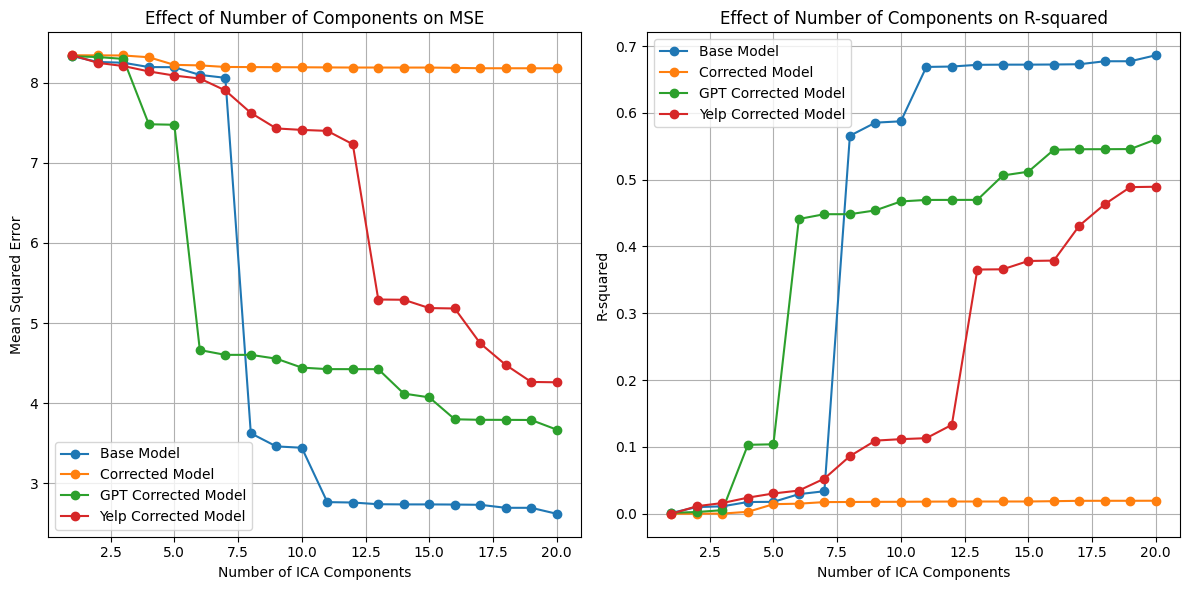

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# Assuming model_data contains different models as described
model_data = {
    "Base Model": Embeddings.drop(columns="posneg_subspace"), 
    "Corrected Model": Corrected_Subspace.drop(columns="posneg_subspace"), 
    "GPT Corrected Model": GPT_Corrected_Subspace.drop(columns="posneg_subspace"),
    "Yelp Corrected Model": Yelp_Corrected_Subspace.drop(columns="posneg_subspace"),
}

# Initialize the plot
plt.figure(figsize=(12, 6))

# Loop through all models in model_data
for model_name, data in model_data.items():
    print(f"Processing {model_name}...")
    
    ica = FastICA(n_components=20, whiten="arbitrary-variance", random_state=43)  # Define ICA
    
    # Split data for training
    X = data.iloc[:, :-1]  # All columns except the last one
    y = data.iloc[:, -1]   # Last column is the target variable (rating)
    
    df_ica = pd.DataFrame(ica.fit_transform(X))  # Fit ICA to data
    df_ica['rating'] = y  # Add target to the DataFrame
    
    # Separate the features (ICA components) and the target variable
    X = df_ica.iloc[:, :20]  # First 20 columns are ICA components (features)
    y = df_ica.iloc[:, 20]   # 21st column (index 20) is the dependent variable (target)
    
    # Initialize lists to store results for this model
    mse_values = []
    r_squared_values = []
    
    # Iterate over the number of components (1 to 20)
    for n_components in range(1, 21):
        # Select the first `n_components` columns of ICA components
        X_n = X.iloc[:, :n_components]
        X_n = sm.add_constant(X_n)  # Add a constant for the regression intercept
        
        # Fit the regression model
        model = sm.OLS(y, X_n).fit()
        
        # Predict on the same data
        predictions = model.predict(X_n)
        
        # Calculate metrics
        mse = np.mean((y - predictions) ** 2)
        r_squared = model.rsquared
        
        # Store the metrics
        mse_values.append(mse)
        r_squared_values.append(r_squared)
    
    # Plot the MSE and R-squared for this model
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 21), mse_values, marker='o', label=model_name)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 21), r_squared_values, marker='o', label=model_name)

# Finalize MSE plot
plt.subplot(1, 2, 1)
plt.title('Effect of Number of Components on MSE')
plt.xlabel('Number of ICA Components')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()

# Finalize R-squared plot
plt.subplot(1, 2, 2)
plt.title('Effect of Number of Components on R-squared')
plt.xlabel('Number of ICA Components')
plt.ylabel('R-squared')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Processing Base Model...


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Processing Corrected Model...
Processing GPT Corrected Model...


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Processing Yelp Corrected Model...


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


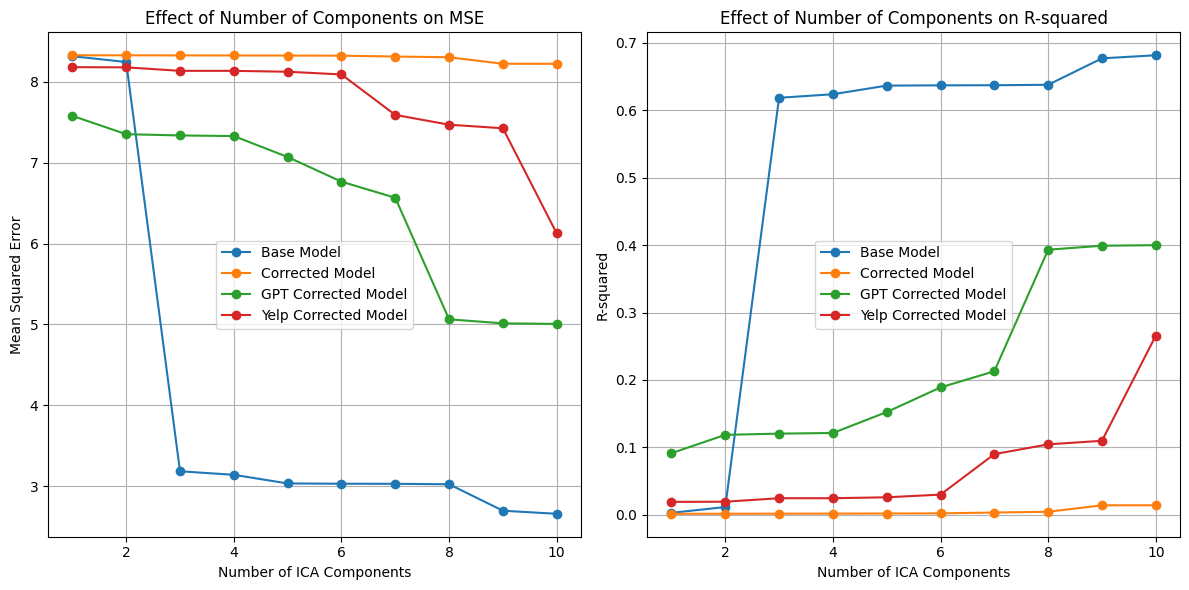

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# Assuming model_data contains different models as described
model_data = {
    "Base Model": Embeddings.drop(columns="posneg_subspace"), 
    "Corrected Model": Corrected_Subspace.drop(columns="posneg_subspace"), 
    "GPT Corrected Model": GPT_Corrected_Subspace.drop(columns="posneg_subspace"),
    "Yelp Corrected Model": Yelp_Corrected_Subspace.drop(columns="posneg_subspace"),
}

# Initialize the plot
plt.figure(figsize=(12, 6))
components = 10
# Loop through all models in model_data
for model_name, data in model_data.items():
    print(f"Processing {model_name}...")
    
    ica = FastICA(n_components=components, whiten="arbitrary-variance", random_state=42)  # Define ICA
    
    # Split data for training
    X = data.iloc[:, :-1]  # All columns except the last one
    y = data.iloc[:, -1]   # Last column is the target variable (rating)
    
    df_ica = pd.DataFrame(ica.fit_transform(X))  # Fit ICA to data
    df_ica['rating'] = y  # Add target to the DataFrame
    
    # Separate the features (ICA components) and the target variable
    X = df_ica.iloc[:, :components]  # First n columns are ICA components (features)
    y = df_ica.iloc[:, components]   # n'th column (index n) is the dependent variable (target)
    
    # Initialize lists to store results for this model
    mse_values = []
    r_squared_values = []
    
    # Iterate over the number of components (1 to 20)
    for n_components in range(1, components+1):
        # Select the first `n_components` columns of ICA components
        X_n = X.iloc[:, :n_components]
        X_n = sm.add_constant(X_n)  # Add a constant for the regression intercept
        
        # Fit the regression model
        model = sm.OLS(y, X_n).fit()
        
        # Predict on the same data
        predictions = model.predict(X_n)
        
        # Calculate metrics
        mse = np.mean((y - predictions) ** 2)
        r_squared = model.rsquared
        
        # Store the metrics
        mse_values.append(mse)
        r_squared_values.append(r_squared)
    
    # Plot the MSE and R-squared for this model
    plt.subplot(1, 2, 1)
    plt.plot(range(1, components+1), mse_values, marker='o', label=model_name)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, components+1), r_squared_values, marker='o', label=model_name)

# Finalize MSE plot
plt.subplot(1, 2, 1)
plt.title('Effect of Number of Components on MSE')
plt.xlabel('Number of ICA Components')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()

# Finalize R-squared plot
plt.subplot(1, 2, 2)
plt.title('Effect of Number of Components on R-squared')
plt.xlabel('Number of ICA Components')
plt.ylabel('R-squared')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Attempting to find word embeddings in maxima of embeddings 

In [9]:
# Parameters
data = model_data['GPT Corrected Model']
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column is the target variable (rating)
ica = FastICA(n_components=20, whiten="arbitrary-variance", random_state=42)  # Define ICA
df_ica = pd.DataFrame(ica.fit_transform(X))  # Fit ICA to data
dim = 20
num_of_topics = 10

# Define Function
def get_clean_words(raw_string):
    """
    Takes in a raw_string and returns the set of words appearing in the string.
    """
    import re
    try:
        clean_text = str(raw_string)  # Convert to string
        clean_text = re.sub(r'<br/><br/>', ' ', clean_text)  # Remove breaks
        clean_text = re.sub(r'/', ' ', clean_text)  # Replace forward slashes with space
        clean_text = re.sub(r'[^a-zA-Z0-9 ]', '', clean_text).lower()  # Remove special characters and lowercase
        words = clean_text.split()  # Split the text into words
        unique_words = set(words)  # Get unique words
        return unique_words
    except Exception as e:
        print(f"Error processing input: {raw_string}. Error: {e}")
        return set()  # Return an empty set in case of failure

# Get Unique Words
mapped_set = map(get_clean_words, Reviews)
my_set = set().union(*mapped_set)

# Convert set to list
review_words_corpus = list(my_set)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dict[Chosen_Model]['huggingface'])

# Tokenize each word in the list
tokenized_words = [tokenizer.tokenize(word) for word in review_words_corpus]

# Flatten the tokenized words list
flat_tokens = [token for sublist in tokenized_words for token in sublist]

# Remove tokens that start with "##"
filtered_tokens = [token for token in flat_tokens if not token.startswith("##")]

# Save each unique element
review_tokens_corpus = list(set(filtered_tokens))

# Generate embeddings
review_word_embeddings = my_encoder(review_tokens_corpus)
ICA_Word_Embeddings = pd.DataFrame(ica.transform(review_word_embeddings))

# Loop through all dimensions and display results
for i in range(dim):
    # Find the n largest values' indices
    largest_indices = ICA_Word_Embeddings[i].nlargest(num_of_topics).index
    # Map indices to words in the corpus
    largest_words = [review_tokens_corpus[idx].replace('▁', '') for idx in largest_indices]

    # Find the n smallest values' indices
    smallest_indices = ICA_Word_Embeddings[i].nsmallest(num_of_topics).index
    # Map indices to words in the corpus
    smallest_words = [review_tokens_corpus[idx].replace('▁', '') for idx in smallest_indices]

    # Display results
    print(f"\nDimension {i + 1}")
    print(f"Words corresponding to the {num_of_topics} largest embeddings:")
    print(largest_words)
    print(f"Words corresponding to the {num_of_topics} smallest embeddings:")
    print(smallest_words)

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors



Dimension 1
Words corresponding to the 10 largest embeddings:
['retro', 'astronaut', 'neon', 'techno', '1962', 'jazz', 'therapy', 'therapy', 'arcade', 'mama']
Words corresponding to the 10 smallest embeddings:
['books', 'books', 'book', 'book', 'fellowship', 'literary', 'fantasy', 'novels', 'bookstore', 'merlin']

Dimension 2
Words corresponding to the 10 largest embeddings:
['awesome', 'violent', 'absurd', 'creature', 'wild', 'wild', 'insane', 'tribal', 'wildly', 'monster']
Words corresponding to the 10 smallest embeddings:
['romance', 'romantic', 'female', 'woman', 'woman', 'bridal', 'actress', 'honeymoon', 'feminine', 'bride']

Dimension 3
Words corresponding to the 10 largest embeddings:
['silk', 'crank', 'aqua', 'mutant', 'aquatic', 'boulder', 'nature', 'nature', 'diver', 'vitamin']
Words corresponding to the 10 smallest embeddings:
['empire', 'fett', 'han', 'imperi', 'rebel', 'republic', 'obi', 'galaxy', 'trilogy', 'trek']

Dimension 4
Words corresponding to the 10 largest embed

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but FastICA was fitted with feature names
  warnings.warn(


# Done

In [ ]:
# Parameters:
ica = ica
dim = 4
num_of_topics = 10


# Define Function
def get_clean_words(raw_string):
    """
    Takes in a raw_string and returns the set of words appearing in the string.
    """
    import re
    try:
        clean_text = str(raw_string)  # Convert to string
        clean_text = re.sub(r'<br/><br/>', ' ', clean_text)  # Remove breaks
        clean_text = re.sub(r'/', ' ', clean_text)  # Replace forward slashes with space
        clean_text = re.sub(r'[^a-zA-Z0-9 ]', '', clean_text).lower()  # Remove special characters and lowercase
        words = clean_text.split()  # Split the text into words
        unique_words = set(words)  # Get unique words
        return unique_words
    except Exception as e:
        print(f"Error processing input: {raw_string}. Error: {e}")
        return set()  # Return an empty set in case of failure
# Get Unique words
mapped_set = map(get_clean_words, Reviews)
my_set = set().union(*mapped_set)

# Convert set to list
review_words_corpus = list(my_set)

# Initialize the tokenizer, good basic tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dict[Chosen_Model]['huggingface'])

# List of words
words = review_words_corpus

# Tokenize each word in the list
tokenized_words = [tokenizer.tokenize(word) for word in words]

# Flatten the tokenized words list
flat_tokens = [token for sublist in tokenized_words for token in sublist]

# Remove tokens that start with "##"
filtered_tokens = [token for token in flat_tokens if not token.startswith("##")]

# Save each unique element:
review_tokens_corpus =  list(set(filtered_tokens))

review_word_embeddings = my_encoder(review_tokens_corpus)
ICA_Word_Embeddings = pd.DataFrame(ica.transform(review_word_embeddings))

# Find the n smallest values' indices
largest_indices = ICA_Word_Embeddings[dim-1].nlargest(num_of_topics).index
# Map indices to ords in the corpus
largest_words = [review_tokens_corpus[i] for i in largest_indices]


print(f"Words corresponding to the {num_of_topics} largest embeddings:")
print(largest_words)

# Find the n smallest values' indices
smallest_indices = ICA_Word_Embeddings[dim-1].nsmallest(num_of_topics).index
# Map indices to words in the corpus
smallest_words = [review_tokens_corpus[i] for i in smallest_indices]


print(f"Words corresponding to the {num_of_topics} smallest embeddings:")
print(smallest_words)